In [1]:
import pandas as pd
import xarray as xr
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt

from fos.util import get_wrf_data_points
from fos.data import snotel_no_ak
from fos import util
from fos.data import snotelmeta 

In [397]:
## import model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [239]:
masks = xr.open_dataset('../data/basin_masks.nc')

sweBC = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/snowmaxBC.nc')
snotelBC = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/maxsnotelBC.nc')

varname = '__xarray_dataarray_variable__'
## add lat and lon values to snotel dataset
data = xr.open_dataset("./site_indices_%s_%s_%s.nc" %('snow','d02','ALL'))
iii, jjj = data.ii_dim.values, data.jj_dim.values
#snotelBC['iii'] = iii
#snotelBC['jjj'] = jjj
lat_snotel = []
lon_snotel = []
for idx in range(703):
    ii = iii[idx]
    jj = jjj[idx]
    lat_snotel.append(lat_wrf.data[jj,ii])
    lon_snotel.append(lon_wrf.data[jj,ii])
#snotelBC['lat'] = lat_snotel
#snotelBC['lon'] = lon_snotel

In [190]:

def xarray_to_dataframe(dataset, variable, keep_dims=None, drop_dims=None):
    """
    Converts an xarray dataset to a pandas DataFrame, keeping a specific variable and specified dimensions.

    Args:
        dataset (xarray.Dataset): The xarray dataset to be converted.
        variable (str): Name of the variable to keep in the DataFrame.
        keep_dims (list or None): List of dimensions to keep in the DataFrame. Default is None (all dimensions).
        drop_dims (list or None): List of dimensions to drop from the DataFrame. Default is None (no dimensions).

    Returns:
        pandas.DataFrame: The resulting DataFrame.

    """
    # Selecting the desired variable
    dataset = dataset[variable]

    # Selecting only the desired dimensions
    if drop_dims:
        dataset = dataset.drop(drop_dims)
    if keep_dims:
        dataset = dataset.drop([dim for dim in dataset.dims if dim not in keep_dims])
   

    # Converting to DataFrame
    df = dataset.to_dataframe().reset_index()

    return df


In [459]:
def _metaread(dir_meta,domain):
 file = "%swrfinput_%s" %(dir_meta,domain)
 data = xr.open_dataset(file)
 lat = data.variables["XLAT"]
 lon = data.variables["XLONG"]
 z = data.variables["HGT"]

 return (lat,lon,z,file)
#These files contain all static fields
domain = "d02"
dir_meta = "/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/"
lat1, lon1, z1, file = _metaread(dir_meta,domain)
lon_wrf = lon1[0,:,:]
lat_wrf = lat1[0,:,:]
z_wrf = z1[0,:,:]
lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

coords = {'lat': (['lat2d','lon2d'], lat_wrf), \
                 'lon': (['lat2d','lon2d'], lon_wrf) }

gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3',]


variants = ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
            'r1i1p1f1','r1i1p1f1','r2i1p1f2',
            'r1i1p2f1','r5i1p1f1','r1i1p1f1',]
   

calendar = ['365_day','proleptic_gregorian','proleptic_gregorian',
            'proleptic_gregorian','365_day','360_day',
             '365_day','proleptic_gregorian', 'proleptic_gregorian',]


ssps = ['ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        'ssp370']

statsmodels = [LinearRegression(),KNeighborsRegressor(n_neighbors=3)]

In [460]:
## save outputs here ## 
output_dict = {
    "basinname": {
        "gcm": {
            "cell": {
                "year": {
                    "statmodel": {
                        "type" : None
                    }
                }
            }
        }
    }
}



## giant nested for loop that does everything ... :( 

nyears = 20
## 1) for each basin of 118
for basinmask in masks.basin_masks[0:20]:
    basinname = basinmask.basin.data.flatten()[0] # need for label
    mask = basinmask.data
    swe_local = sweBC.where(mask)
    ## inefficient way of getting snotel data... ##
    snotel_local = {}
    lat_local = lat_wrf.data[mask.astype(bool)]
    lon_local = lon_wrf.data[mask.astype(bool)]
    ## 2) for each gcm type of 9
    for idx,gcm  in enumerate(gcms):
        my_snotel = []
        mod = f'{gcm}_{variants[idx]}_{ssps[idx]}' # need for label
        snotel_mod = snotelBC.sel(gcm = mod)
        swe_local_mod = swe_local.sel(gcm = mod) ## pick one gcm, then you just have spatial + timeseries
        swe_data_flat = swe_local_mod['__xarray_dataarray_variable__'].data[:,mask.astype(bool)]
        years = swe_local_mod['time'].data
        ## inefficient, for each site of 703 check if it's in bounds of the basin 
        for idx,site in enumerate(snotelBC.site):
            tlat = lat_snotel[idx]
            tlon = lon_snotel[idx]
            if (tlat in lat_local) & (tlon in lon_local):
                my_snotel.append(snotel_mod.sel(site = idx))
        if len(my_snotel)  > 0:
            ## turn them in to pd dataframes for the modeling component
            snotel_local_mod = xr.concat(my_snotel, dim = 'site')
            snotel_df = xarray_to_dataframe(snotel_local_mod, varname, keep_dims = ['time','site'], drop_dims = ['gcm'])
            snotel_df = snotel_df.pivot(index = 'time', columns='site', values=varname)

            wrf_df = xarray_to_dataframe(swe_local_mod, varname, keep_dims = ['time','lat2d','lon2d'], drop_dims = ['gcm'])
            wrf_df = wrf_df[~wrf_df[varname].isnull()].reset_index().drop('index', axis=1)
            wrf_df['latlonid'] = wrf_df['lat2d'].astype(str) + ', ' + wrf_df['lon2d'].astype(str)


            ## 3) for each cell in the basin (treat each grid cell as an independent hydrologic unit  )
            for llid in np.unique(wrf_df.latlonid)[0:1]: # need for label
                wrfdata = wrf_df[wrf_df.latlonid == llid]
                wrfdata.index = wrfdata.time
                xy = pd.concat([test, wrfdata[varname]], axis = 1)
                xy = xy.rename(columns={varname: "wrfgridsnow"})
                nsnotel=len(xy.columns)-1
                xcol = xy.columns[0:nsnotel]
                ycol = 'wrfgridsnow'

                ## 4) for each year 
                for yr in range(years[0] + nyears, years[-1]):
                    X_train = xy[xcol].loc[yr-nyears:yr].values.reshape((-1, nsnotel))
                    X_test = xy[xcol].loc[yr].values.reshape((-1, nsnotel))
                    y_train = xy[ycol].loc[yr-nyears:yr]
                    y_test = xy[ycol].loc[yr]
                    ## 5) for each model
                    for model in statsmodels:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)

                        ## save it in the right place ## 
                        output_dict[basinname, mod, llid, yr, str(model), 'pred'] = y_pred[0] 
                        output_dict[basinname, mod, llid, yr, str(model), 'obs'] = y_test


In [461]:
basins = []
gcm_mods = []
cells = []
years = []
statmodels = []
categs = []
values = []

tmp_df = pd.DataFrame()
for key in output_dict:
    if key != 'basinname':
        basins.append(key[0])
        gcm_mods.append(key[1])
        cells.append(key[2])
        years.append(key[3])
        statmodels.append(key[4])
        categs.append(key[5])
        values.append(output_dict[key])
output_df = pd.DataFrame({'basin':basins, 'gcm':gcm_mods, 'cell':cells, 'year':years, 'statmodel':statmodels, 'categ':categs, 'value':values})

In [462]:
output_df

,basin,gcm,cell,year,statmodel,categ,value
0,Gunnison,cesm2_r11i1p1f1_ssp370,"116, 188",2001,LinearRegression(),pred,184.405670
1,Gunnison,cesm2_r11i1p1f1_ssp370,"116, 188",2001,LinearRegression(),obs,210.232101
2,Gunnison,cesm2_r11i1p1f1_ssp370,"116, 188",2001,KNeighborsRegressor(n_neighbors=3),pred,178.952942
3,Gunnison,cesm2_r11i1p1f1_ssp370,"116, 188",2001,KNeighborsRegressor(n_neighbors=3),obs,210.232101
4,Gunnison,cesm2_r11i1p1f1_ssp370,"116, 188",2002,LinearRegression(),pred,132.729340
...,...,...,...,...,...,...,...
42763,Upper San Juan,ec-earth3_r1i1p1f1_ssp370,"100, 159",2098,KNeighborsRegressor(n_neighbors=3),obs,0.229340
42764,Upper San Juan,ec-earth3_r1i1p1f1_ssp370,"100, 159",2099,LinearRegression(),pred,1.898877
42765,Upper San Juan,ec-earth3_r1i1p1f1_ssp370,"100, 159",2099,LinearRegression(),obs,1.490642
42766,Upper San Juan,ec-earth3_r1i1p1f1_ssp370,"100, 159",2099,KNeighborsRegressor(n_neighbors=3),pred,5.457958


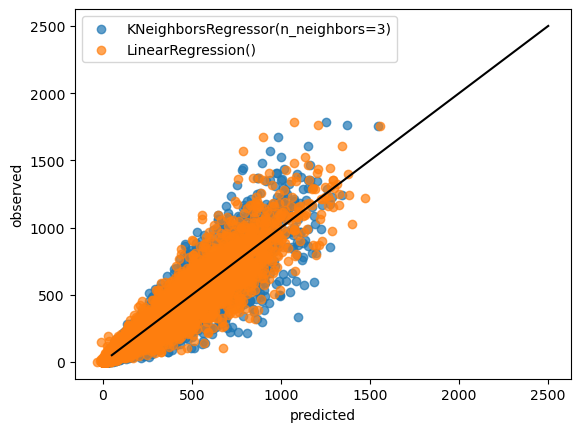

In [463]:
fig,ax = plt.subplots()
for statmodel in np.unique(output_df.statmodel):
    tmp = output_df[output_df.statmodel == statmodel]
    pred = tmp[tmp.categ == 'pred'].value
    obs = tmp[tmp.categ == 'obs'].value
    years = tmp[tmp.categ == 'pred'].year
    ax.scatter(pred,obs, alpha = 0.7, label = statmodel)
ax.legend()
ax.set_xlabel('predicted')
ax.set_ylabel('observed')
ax.plot([50,2500],[50,2500], 'k-')
plt.show()


/glade/scratch/mcowherd/ipykernel_217264/1011686169.py:7: RuntimeWarning: divide by zero encountered in divide
  mae = np.abs((np.array(pred)-np.array(obs)))/np.array(obs)


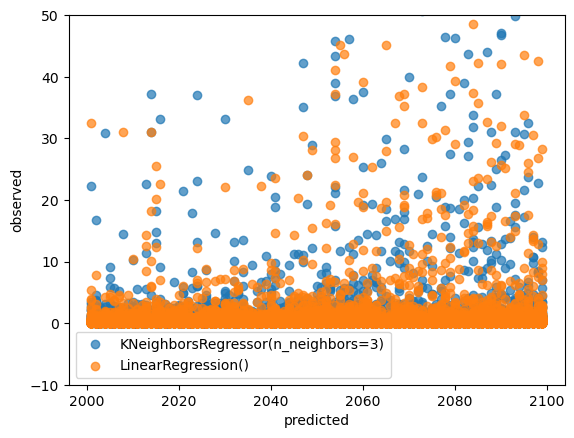

In [464]:
fig,ax = plt.subplots()
for statmodel in np.unique(output_df.statmodel):
    tmp = output_df[output_df.statmodel == statmodel]
    pred = tmp[tmp.categ == 'pred'].value
    obs = tmp[tmp.categ == 'obs'].value
    years = tmp[tmp.categ == 'pred'].year
    mae = np.abs((np.array(pred)-np.array(obs)))/np.array(obs)
    ax.scatter(years, mae, alpha = 0.7, label = statmodel)
ax.legend()
ax.set_xlabel('predicted')
ax.set_ylabel('observed')
ax.set_ylim((-10,50))
plt.show()


In [ ]:
fig,ax = plt.subplots()


In [ ]:
## ONE OTHER IDEA THAT ISN'T LINEAR REGRESSION: CHECK FOR PATTERN REPEATABILITY ALONG THE LINES OF PFLUG... 
## RELATED BECAUSE WE HYPOTHESIZE THAT THE LACK OF PATTERN REPEATABILITY IS WHAT IS LEADING TO DECLINE OF PREDICTIONS
## AND THAT NEW METHODS (ML SPECIFICALLY) CAN LEARN TO OVERCOME THIS. SEE SHIHENG'S PAPER FOR LSTM SPATIAL PREDICTIONS,
## OR KNN FROM ZAKERI (UNPUB)

In [45]:
## OLD VERSION
import glob
import xarray as xr
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

files = glob.glob('/glade/u/home/mcowherd/nh-WRF/time_series/*') ## pre-made files with snotel stations and basin-wide average peak SWE, fro mbefore
data = xr.open_dataset(files[0]).to_dataframe()
pvars = list(data.columns)[0:-1]
output_var = 'maxval_basin' # Basin-wide snow water equivalent

## uses the first 86 years as training, then predicts the rest. would do this in a slightly different way for the n-1 format.
train_data = data[0:86]
test_data = data[86:]
y_train = np.array(train_data[output_var])
y_test = np.array(test_data[output_var])

X_train = train_data[pvars].values.reshape((-1, len(pvars)))
X_test = test_data[pvars].values.reshape((-1, len(pvars)))
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
basin = files[0].split('/')[-1].split('.')[0]
outputs = ({'basin': basin, 'model':'linreg_86', 'MSE': mean_squared_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'ytest': y_test, 'ypred':y_pred})
outputs


{'basin': 'Powder',
 'model': 'linreg_86',
 'MSE': 0.24231644137370587,
 'R2': 0.11193809038368874,
 'ytest': array([0.6530202 , 1.011659  , 0.79945916, 0.5415832 , 0.73667663,
        1.4585127 , 0.76249003, 1.449996  , 0.7457103 , 0.56349224,
        1.1674377 , 0.96945876, 3.0615075 , 0.98176   , 0.77431935,
        0.5429413 , 0.7134076 , 0.5746162 , 1.3671218 , 0.8791103 ,
        0.5872054 , 0.3046924 , 0.4421071 , 1.2631923 , 0.74674207,
        0.6335426 , 1.0624342 , 0.63923955, 0.3218614 , 0.7463375 ,
        1.8258287 ]),
 'ypred': array([0.75346495, 0.91786574, 0.84063875, 1.01431579, 1.02290049,
        0.88085993, 1.1508626 , 1.10636857, 0.82195652, 0.91068072,
        0.76286304, 0.7505259 , 1.05726376, 0.81705876, 0.82229121,
        0.57087475, 0.63451016, 0.87204086, 0.98009773, 1.14522067,
        0.82923957, 0.66335336, 0.66762829, 0.69774451, 0.93895648,
        0.81234081, 0.71747949, 0.65496396, 0.8923853 , 0.72650461,
        0.92531766])}

In [51]:
from pathlib import Path
from sklearn.linear_model import LinearRegression

## this is the idea behind the n-1, but the current data setup is for the csv. 
for max_year in range(2020, 2097):
# max_year = 2020
    df_train = df[df.wyear <= max_year]
    df_group = df_train.groupby("pt")
    # df_group_test = df[df.wyear > max_year].groupby("pt")] 
    # linear regression for each group

    res = df_group.apply(lambda x: LinearRegression().fit(x[['maxval_pt']].values, x[['maxval_basin']].values))
    res.name = 'lr'
    lr_df = pd.merge(df, res, how='left', left_on='pt', right_on='pt')
    df_test = lr_df[lr_df.wyear == max_year+1]
    df_test['lr_res'] = df_test.apply(lambda x: max([0,x['lr'].predict([[x['maxval_pt']]])[0][0]]), axis=1)
    df_test['lr_res_diff'] = df_test['lr_res'] - df_test['maxval_basin']

    all_res.append(df_test)

AttributeError: 'DataFrame' object has no attribute 'wyear'

In [ ]:
vals = []
import numpy as np
for entry in all_res:
    vals.append(np.nanmean(entry['lr_res_diff'] / entry['maxval_basin']))
fig,ax = plt.subplots()
ax.plot(range(2021,2098),vals)
ax.set_ylabel('percent error')
plt.show()